In [10]:
#base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns
import warnings
import random
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from scipy.spatial import distance
from scipy import stats
from sklearn.metrics import mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV

In [ ]:
#input shape n_samples x timesteps x n_features
#https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/VAE_TimeSeries/VAE_TimeSeries.ipynb
#https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [3]:
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col = [0])

def filter_rare_bacteria(df):
    
    rare_bacteria_df = pd.DataFrame((df == 0).astype(int).sum(axis = 0))
    rare_bacteria_col = rare_bacteria_df[rare_bacteria_df[0] > 250].index
    df_filtered = df.drop(rare_bacteria_col, axis = 1)
    
    return df_filtered

filtered_df = filter_rare_bacteria(df)
filtered_df.index = pd.to_datetime(filtered_df.index)

x_train, x_test = filtered_df.iloc[:220], filtered_df.iloc[221:]

scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

In [5]:
def temporalize(X, y, lookback):
    output_X = []
    #output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        #output_y.append(y[i+lookback+1])
        
    return output_X #, output_y

In [6]:
timesteps = 14
n_features = normalized_train.shape[1]

X_temp = temporalize(X = normalized_train, y = np.zeros(len(normalized_train)), lookback = timesteps)
y_temp = temporalize(X = normalized_test, y = np.zeros(len(normalized_test)), lookback = timesteps)

n_features = normalized_train.shape[1]


#scaled sequential x
X_array = np.array(X_temp)
X_array = X_array.reshape(X_array.shape[0], timesteps, n_features) 

#scaled sequential y
y_array = np.array(y_temp)
y_array = y_array.reshape(y_array.shape[0], timesteps, n_features) 

In [ ]:
#randomized model
def tune_model(dropout_rate):
    
    #SGD
    learning_rate = 0.1
    momentum = 0.8
    
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=True)

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(252, input_shape=(timesteps,n_features), return_sequences=True))
    
    model.add(tf.keras.layers.Dense(dropout_rate))

    model.add(tf.keras.layers.LSTM(16, return_sequences=False))

    model.add(tf.keras.layers.RepeatVector(timesteps)) #bridge between encoder and the decoder

    model.add(tf.keras.layers.LSTM(16, return_sequences=True))
              
    model.add(tf.keras.layers.Dense(dropout_rate))

    model.add(tf.keras.layers.LSTM(252, return_sequences=True))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))

    model.compile(loss='mae', optimizer=sgd)
    
    return model


seed = 7
np.random.seed(seed)

#build model
model = KerasRegressor(build_fn=tune_model, verbose=0)

#params
batch_size = [8, 16, 32]
epochs = [100]
#h_neurons = [64, 126, 252]
#l_neurons = [16, 32, 64]
dropout_rate = [0.1, 0.2, 0.3]

#param grid
param_grid = dict(
    batch_size=batch_size,
    epochs=epochs,
    dropout_rate = dropout_rate
)

#validation
kfld = KFold(n_splits=3,
             shuffle=False)

grid = RandomizedSearchCV(estimator=model,
                          cv=kfld,
                          param_distributions=param_grid, 
                          verbose=20,
                          n_iter=10,
                          n_jobs=1
                         )

#early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)

grid_result = grid.fit(X_array, X_array )

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START batch_size=8, dropout_rate=0.1, epochs=100..................
[CV 1/3; 1/9] END batch_size=8, dropout_rate=0.1, epochs=100;, score=-0.082 total time= 1.0min
[CV 2/3; 1/9] START batch_size=8, dropout_rate=0.1, epochs=100..................
[CV 2/3; 1/9] END batch_size=8, dropout_rate=0.1, epochs=100;, score=-0.080 total time= 1.4min
[CV 3/3; 1/9] START batch_size=8, dropout_rate=0.1, epochs=100..................
[CV 3/3; 1/9] END batch_size=8, dropout_rate=0.1, epochs=100;, score=-0.097 total time= 1.4min
[CV 1/3; 2/9] START batch_size=8, dropout_rate=0.2, epochs=100..................
[CV 1/3; 2/9] END batch_size=8, dropout_rate=0.2, epochs=100;, score=-0.082 total time= 1.1min
[CV 2/3; 2/9] START batch_size=8, dropout_rate=0.2, epochs=100..................
[CV 2/3; 2/9] END batch_size=8, dropout_rate=0.2, epochs=100;, score=-0.081 total time= 1.4min
[CV 3/3; 2/9] START batch_size=8, dropout_rate=0.2, epochs=1

In [ ]:
grid_result.best_params_

In [ ]:
grid_result.best_params_

In [17]:
grid_result.best_score_

-0.08704338471094768

In [18]:
learning_rate = 0.1
momentum = 0.8

sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=True)

    
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(252, input_shape=(timesteps,n_features), return_sequences=True))

model.add(tf.keras.layers.LSTM(16, return_sequences=False))

model.add(tf.keras.layers.RepeatVector(timesteps)) #bridge between encoder and the decoder

model.add(tf.keras.layers.LSTM(16, return_sequences=True))

model.add(tf.keras.layers.LSTM(252, return_sequences=True))


model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))

model.compile(optimizer=sgd,
              loss='mae',
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.CosineSimilarity()]
             )

# fit model
history = model.fit(X_array, X_array, 
                  epochs = 100,
                  batch_size = 8,
                  validation_data = (y_array, y_array),
                  verbose = 0,
                  shuffle = False)

In [23]:
loss_df = make_loss_df(history)

In [28]:
model.save('LSTM_RECONSTRUCTION/model2_simple_best_params.h5')

In [26]:
def make_loss_df(history):
    
    df = pd.DataFrame(history.history)
    df['epoch'] = df.index
    df['cosine_distance'] = 1 - df['cosine_similarity']
    df['val_cosine_distance'] = 1 - df['val_cosine_similarity']
    
    return df

def plot_loss_df(loss_df):
        
    sns.lineplot(x = loss_df['epoch'], y = loss_df['loss'], color = 'black')
    sns.scatterplot(x = loss_df['epoch'], y = loss_df['loss'], color = 'black')

    sns.lineplot(x = loss_df['epoch'], y = loss_df['val_loss'], color = 'orange')
    sns.scatterplot(x = loss_df['epoch'], y = loss_df['val_loss'], color = 'orange') 
    
    #plt.title('no timesteps: {}'.format(n))
    plt.show()
    
    sns.lineplot(x = loss_df['epoch'], y = loss_df['cosine_distance'], color = 'black')
    sns.scatterplot(x = loss_df['epoch'], y = loss_df['cosine_distance'], color = 'black')

    sns.lineplot(x = loss_df['epoch'], y = loss_df['val_cosine_distance'], color = 'orange')
    sns.scatterplot(x = loss_df['epoch'], y = loss_df['val_cosine_distance'], color = 'orange')  
    
    #plt.title('no timesteps: {}'.format(n))
    plt.show()

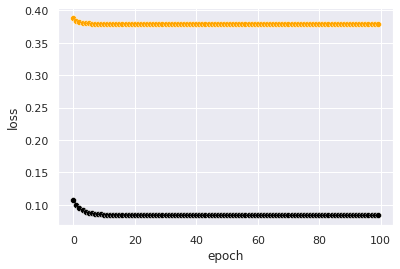

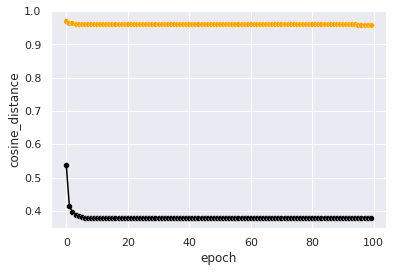

In [27]:
plot_loss_df(loss_df)

In [ ]:
#history_n14['n'] = 14
history_n7['n'] = 7
history_n4['n'] = 4
history_n2['n'] = 2
history_n14['n'] = 14
history_n28['n'] = 28

h_df = history_n4.append(history_n2).append(history_n7).append(history_n14).append(history_n28)
h_df = h_df.reset_index()

In [ ]:
#sns.lineplot(x = h_df['epoch'], y = h_df['loss'], palette = 'Set2', hue = h_df['n'])
#sns.lineplot(x = history_n28['epoch'], y = history_n28['loss'])
sns.lineplot(x = history_n28['epoch'], y = history_n28['val_loss'])
#plt.savefig('LSTM_RECONSTRUCTION/lstm_ae_train_loss_no_relu.png')

In [ ]:
#sns.lineplot(x = h_df['epoch'], y = h_df['loss'], palette = 'Set2', hue = h_df['n'])
sns.lineplot(x = history_n28['epoch'], y = history_n28['loss'])
sns.lineplot(x = history_n28['epoch'], y = history_n28['val_loss'])
#plt.savefig('LSTM_RECONSTRUCTION/lstm_ae_train_loss_no_relu.png')

In [ ]:
sns.lineplot(x = history_n28['epoch'], y = history_n28['loss'])

In [ ]:
sns.lineplot(x = h_df['epoch'], y = h_df['val_loss'], palette = 'Set2', hue = h_df['n'])
#plt.savefig('LSTM_RECONSTRUCTION/lstm_ae_test_loss_no_relu.png')

In [ ]:
sns.lineplot(x = history_n28['epoch'], y = history_n28['cosine_distance'])
sns.lineplot(x = history_n28['epoch'], y = history_n28['val_cosine_distance'])

## analyse weights

In [ ]:
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)
print("No units: ", units)

In [ ]:
for i in range(len(model.layers)):
    
    try:
        W = model.layers[i].get_weights()[0]

        W_i = W[:, :units] #input gate
        W_f = W[:, units: units * 2] #forget gate
        W_c = W[:, units * 2: units * 3] #candidate memory
        W_o = W[:, units * 3:] #output gate
        
        print(i, np.round(W_i.mean(), 2))
    except:
        print(i)

## loss

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df['epoch'] = loss_df.index

loss_df['cosine_distance'] = 1 - loss_df['cosine_similarity']
loss_df['val_cosine_distance'] = 1 - loss_df['val_cosine_similarity']

In [ ]:
#loss
sns.lineplot(x = loss_df['epoch'], y = loss_df['loss'], color = 'black')
sns.scatterplot(x = loss_df['epoch'], y = loss_df['loss'], color = 'black')

sns.lineplot(x = loss_df['epoch'], y = loss_df['val_loss'], color = 'orange')
sns.scatterplot(x = loss_df['epoch'], y = loss_df['val_loss'], color = 'orange')  

In [ ]:
#loss
sns.lineplot(x = loss_df['epoch'], y = loss_df['mean_absolute_percentage_error'], color = 'black')
sns.scatterplot(x = loss_df['epoch'], y = loss_df['mean_absolute_percentage_error'], color = 'black')

sns.lineplot(x = loss_df['epoch'], y = loss_df['val_mean_absolute_percentage_error'], color = 'orange')
sns.scatterplot(x = loss_df['epoch'], y = loss_df['val_mean_absolute_percentage_error'], color = 'orange')  

In [ ]:
yhat = model.predict(y, verbose=0)

In [ ]:
def denorm_data(yhat, y):
    
    for i in range(0, 7):
        yhat[:, i, :] = scaler.inverse_transform(yhat[:, i, :])
        yhat[yhat<0] = 0

        y[:, i, :] = scaler.inverse_transform(y[:, i, :])
        y[y<0] = 0
        
    return yhat, y

In [ ]:
yhat_denorm, y_denorm = denorm_data(yhat, y)

In [ ]:
sns.distplot(y_denorm)

In [ ]:
sns.distplot(yhat_denorm[4, :, 11])

In [ ]:
for i in range(yhat_denorm.shape[0]):
    
    sns.lineplot(x = [i for i in range(7)], y = yhat_denorm[i, :, 11], color = 'orange')
    sns.scatterplot(x = [i for i in range(7)], y = yhat_denorm[i, :, 11], color = 'orange')

    sns.lineplot(x = [i for i in range(7)], y = y_denorm[i, :, 11], color = 'black')
    sns.scatterplot(x = [i for i in range(7)], y = y_denorm[i, :, 11], color = 'black')
    
    plt.show()

In [ ]:
#policzyc metryke dla kazdego batchu X.shape[0] i podzielic przez ilsoc batchy
RHO = []
COSINE_DISTANCE = []
BC = []


for batch in range(y.shape[0]):
    
    y_true = y_denorm[batch, :, :]
    y_pred = yhat_denorm[batch, :, :]
    
    rho = np.array([stats.spearmanr(y_true[day, :], y_pred[day, :])[0] for day in range(y.shape[1])]).mean()
    cosine_distance = np.array([distance.cosine(y_true[day, :], y_pred[day, :]) for day in range(y.shape[1])]).mean()
    bc_distance = np.array([distance.braycurtis(y_true[day, :], y_pred[day, :]) for day in range(y.shape[1])]).mean()
    
    RHO.append(rho)
    COSINE_DISTANCE.append(cosine_distance)
    BC.append(bc_distance)

In [ ]:
error_df = pd.DataFrame(list(zip(RHO, COSINE_DISTANCE, BC)), columns = ['RHO', 'COSINE_DISTANCE', 'BC'])

In [ ]:
rho_df = pd.DataFrame(RHO, columns = ['value'])
rho_df['distance'] = 'RHO'

cosine_df = pd.DataFrame(COSINE_DISTANCE, columns = ['value'])
cosine_df['distance'] = 'COSINE_DISTANCE'

bc_df = pd.DataFrame(BC, columns = ['value'])
bc_df['distance'] = 'BC'

distance_df = rho_df.append(cosine_df).append(bc_df)

In [ ]:
sns.boxplot(y = distance_df['value'], x = distance_df['distance'], orient = 'v')

In [ ]:
sns.regplot(x = error_df['RHO'], y = error_df['COSINE_DISTANCE'])

In [ ]:
sns.regplot(x = error_df['RHO'], y = error_df['BC'])

In [ ]:
sns.regplot(x = error_df['COSINE_DISTANCE'], y = error_df['BC'])